In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_all_data
from prepare import prep_store_data

In [2]:
def nulls_by_col(df):
    '''
    Funciton used to find missing information in each column
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing/rows
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'pct_rows_missing': pct_missing})
    
def nulls_by_row(df):
    '''
    Function used to find missing information in each row
    '''
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    rows_missing = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing})\
                     .reset_index().groupby(['num_cols_missing','pct_cols_missing']).count()\
                     .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    
    return rows_missing
    
def df_summary(df):
    '''
    Funciton summarizes our created data frame with information on: shape, type & null info, desribe function from pandas library, null values by column, null values by row, and value counts
    '''
    print('--- Shape: {} ---'.format(df.shape))
    print('--- Info ---')
    df.info()
    print('--- Descriptions ---')
    print(df.describe(include='all'))
    print('--- Nulls By Column')
    print(nulls_by_col(df))
    print('--- Nulls By Row')
    print(nulls_by_row(df))

In [3]:
df = prep_store_data(get_all_data())

In [4]:
df_summary(df)

--- Shape: (913000, 21) ---
--- Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 21 columns):
item_id                913000 non-null int64
sale_amount            913000 non-null float64
sale_id                913000 non-null int64
store_id               913000 non-null int64
item_brand             913000 non-null object
item_name              913000 non-null object
item_price             913000 non-null float64
item_upc12             913000 non-null object
item_upc14             913000 non-null object
store_address          913000 non-null object
store_city             913000 non-null object
store_state            913000 non-null object
store_zipcode          913000 non-null object
year                   913000 non-null int64
quarter                913000 non-null int64
month                  913000 non-null int64
day_of_month           913000 non-null int64
day_of_week            913000 non-null object
weekend v

# ---

In [7]:
aggregation = 'sum'

train = df[:'2016'].sale_amount.resample('M').agg(aggregation)
test = df['2017':].sale_amount.resample('M').agg(aggregation)

In [8]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 60
Training Observations: 48
Testing Observations: 12


In [9]:
pd.concat([train.head(3), train.tail(3)])

sale_date
2013-01-31 00:00:00+00:00    454904.0
2013-02-28 00:00:00+00:00    459417.0
2013-03-31 00:00:00+00:00    617382.0
2016-10-31 00:00:00+00:00    863637.0
2016-11-30 00:00:00+00:00    891448.0
2016-12-31 00:00:00+00:00    663411.0
Name: sale_amount, dtype: float64

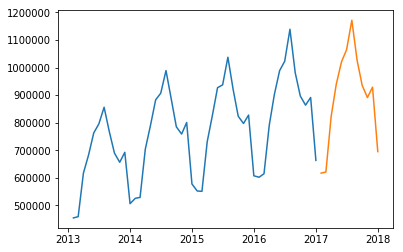

In [10]:
plt.plot(train)
plt.plot(test)
plt.show()

In [11]:
ts_data = df.sale_amount.resample('M').agg(aggregation)

In [12]:
train_size = int(len(ts_data) * 0.66)
train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

Observations: 60
Training Observations: 39
Testing Observations: 21


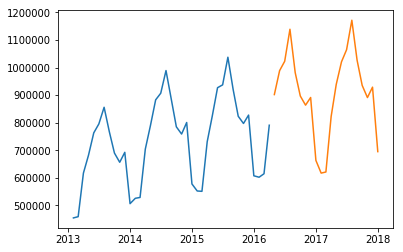

In [13]:
plt.plot(train_1)
plt.plot(test_1)
plt.show()

# simple average

In [14]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat.head()

,actual,avg_forecast
sale_date,,
2017-01-31 00:00:00+00:00,617306.0,770224.416667
2017-02-28 00:00:00+00:00,621369.0,770224.416667
2017-03-31 00:00:00+00:00,822667.0,770224.416667
2017-04-30 00:00:00+00:00,938862.0,770224.416667
2017-05-31 00:00:00+00:00,1020686.0,770224.416667


In [15]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

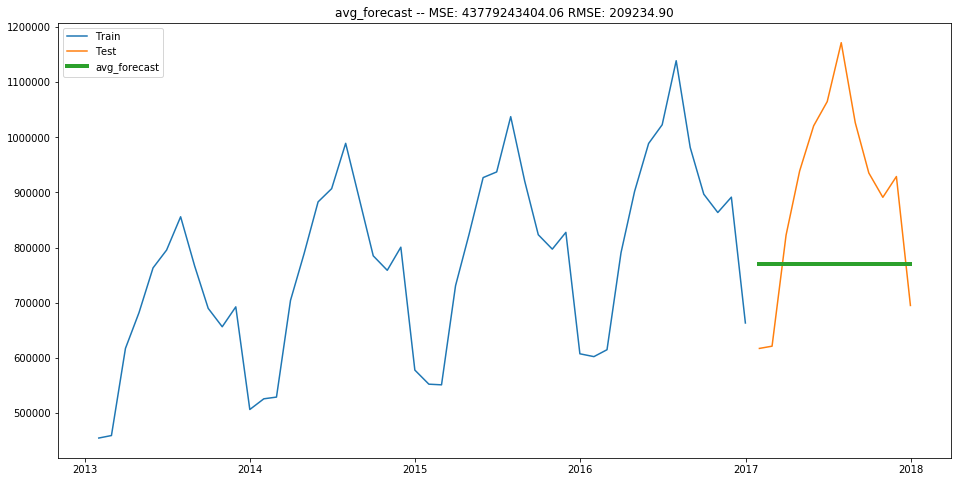

In [16]:
plot_and_eval(yhat.avg_forecast)

# moving average

In [17]:
periods = 12
yhat['moving_avg_forecast_12'] = train.rolling(12).mean().iloc[-1]

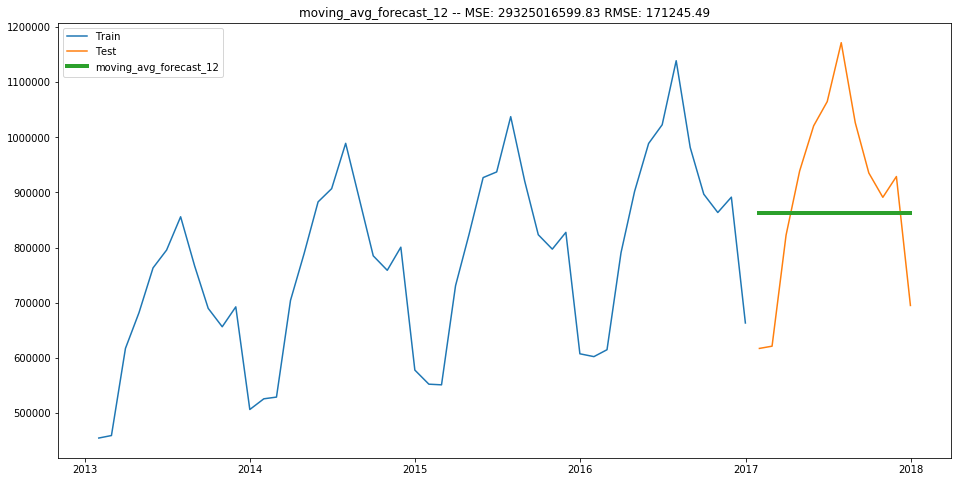

In [18]:
plot_and_eval(yhat.moving_avg_forecast_12)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

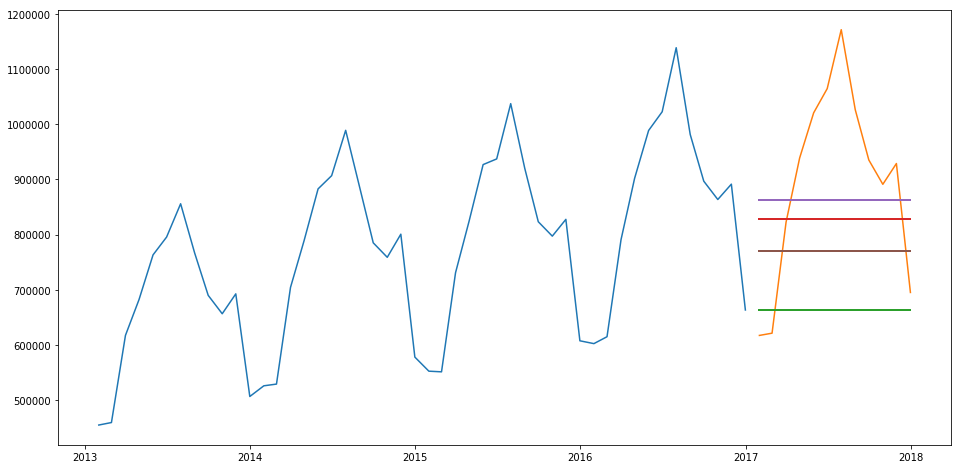

In [19]:
period_vals = [1, 4, 12, 48, 90, 120]
for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

# Holt's linear trend model

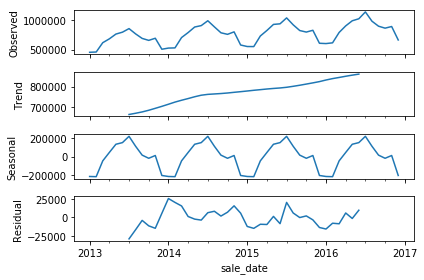

In [20]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

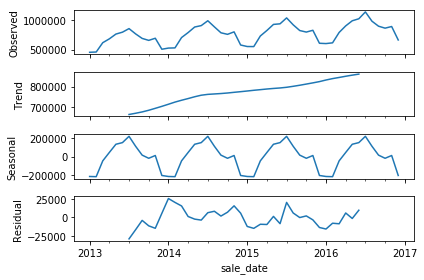

In [21]:
train = df[:'2016'].sale_amount.resample('M').agg(aggregation)
test = df['2017':].sale_amount.resample('M').agg(aggregation)

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

# Based on previous year/month/etc (your choice)

In [22]:
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='sale_date')\
    .set_index(train['2016'].index + 366)\
    .iloc[:-1]

yhat['last_year'] = using_last_year

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

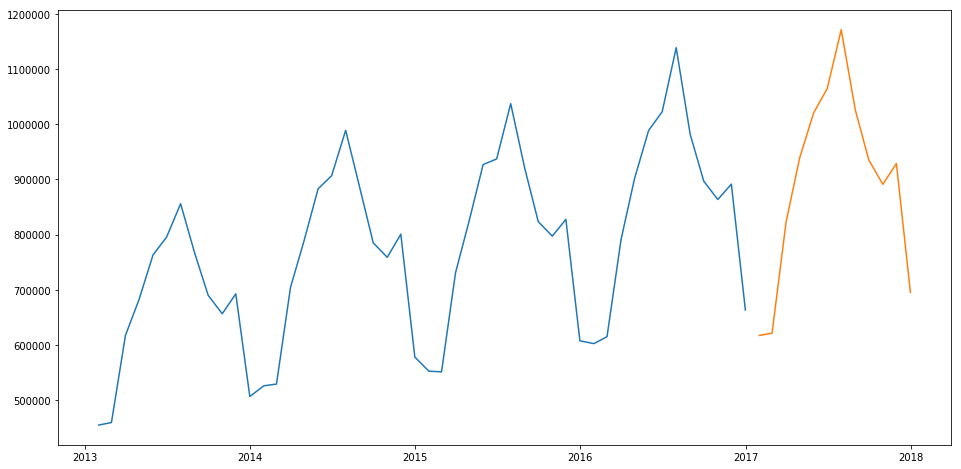

In [23]:
plot_and_eval(yhat.last_year, linewidth=1)

# SAAS

In [136]:
df = pd.read_csv('saas.csv',          
              engine='python',
              header=None,
              index_col=False,
              names=['Month_Invoiced', 'Customer_Id', 'Invoice_Id', 'Subscription_Type', 'Amount'],
              na_values='-',
              usecols=[0, 1, 2, 3, 4, 5],
              parse_dates=['Month_Invoiced'])

In [137]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
1,2014-01-31,1000000,5000000,0.0,0.0
2,2014-01-31,1000001,5000001,2.0,10.0
3,2014-01-31,1000002,5000002,0.0,0.0
4,2014-01-31,1000003,5000003,0.0,0.0


In [138]:
df.shape

(790459, 5)

In [139]:
def parse_sales_date(df):
    df.index = pd.to_datetime(df.index, utc=True)
    return df
def set_date_index(df):
    return df.set_index('Month_Invoiced')

In [140]:
df.head(15)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
1,2014-01-31,1000000,5000000,0.0,0.0
2,2014-01-31,1000001,5000001,2.0,10.0
3,2014-01-31,1000002,5000002,0.0,0.0
4,2014-01-31,1000003,5000003,0.0,0.0
5,2014-01-31,1000004,5000004,1.0,5.0
6,2014-01-31,1000005,5000005,2.0,10.0
7,2014-01-31,1000006,5000006,0.0,0.0
8,2014-01-31,1000007,5000007,0.0,0.0
9,2014-01-31,1000008,5000008,0.0,0.0


In [141]:
df = df.drop(df.index[0])

In [142]:
df = parse_sales_date(df)

In [143]:
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'], errors='coerce')

In [144]:
#df = parse_sales_date(df)
df = set_date_index(df)

In [145]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [146]:
df.index

DatetimeIndex(['2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Month_Invoiced', length=790458, freq=None)

In [147]:
df_summary(df)

--- Shape: (790458, 4) ---
--- Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
Customer_Id          790458 non-null object
Invoice_Id           790458 non-null object
Subscription_Type    790458 non-null object
Amount               790458 non-null object
dtypes: object(4)
memory usage: 30.2+ MB
--- Descriptions ---
       Customer_Id Invoice_Id Subscription_Type  Amount
count       790458     790458            790458  790458
unique       29400     790458                 5       5
top        1015712    5741190               0.0     0.0
freq            48          1            496410  496410
--- Nulls By Column
None
--- Nulls By Row
  num_cols_missing pct_cols_missing  Month_Invoiced
0                0              0.0          790458


In [150]:
train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('W').agg(aggregation)

In [151]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 84
Training Observations: 36
Testing Observations: 48


In [152]:
pd.concat([train.head(3), train.tail(3)])

Month_Invoiced
2014-01-31    0.010.00.00.05.010.00.00.00.00.00.00.00.05.020...
2014-02-28    0.010.05.00.05.010.00.00.00.00.00.00.00.05.020...
2014-03-31    0.010.00.05.010.00.00.00.00.00.00.05.020.00.00...
2016-10-31    0.00.05.05.05.020.05.00.00.010.05.015.00.00.00...
2016-11-30    0.00.05.05.05.020.05.00.00.010.05.015.00.00.00...
2016-12-31    5.00.05.05.05.020.05.00.00.010.05.015.00.00.00...
Name: Amount, dtype: object

In [153]:
pd.concat([test.head(3), test.tail(3)])

Month_Invoiced
2017-02-05    5.00.05.05.05.020.05.00.05.010.05.015.00.00.00...
2017-02-12                                                    0
2017-02-19                                                    0
2017-12-17                                                    0
2017-12-24                                                    0
2017-12-31    5.00.05.05.05.020.00.05.05.05.015.00.00.00.00....
Name: Amount, dtype: object

# Mall Data

In [5]:
from fbprophet import Prophet

In [6]:
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,...,store_state,store_zipcode,year,quarter,month,day_of_month,day_of_week,weekend vs. weekday,sales_total,day_over_day
sale_date,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,...,TX,78253,2013,1,1,1,Tuesday,False,10.92,NaN
2013-01-02 00:00:00+00:00,1,11.0,2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,...,TX,78253,2013,1,1,2,Wednesday,False,9.24,-1.68
2013-01-03 00:00:00+00:00,1,14.0,3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,...,TX,78253,2013,1,1,3,Thursday,False,11.76,2.52
2013-01-04 00:00:00+00:00,1,13.0,4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,...,TX,78253,2013,1,1,4,Friday,False,10.92,-0.84
2013-01-05 00:00:00+00:00,1,10.0,5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,...,TX,78253,2013,1,1,5,Saturday,False,8.40,-2.52


In [7]:
df.dtypes

item_id                  int64
sale_amount            float64
sale_id                  int64
store_id                 int64
item_brand              object
item_name               object
item_price             float64
item_upc12              object
item_upc14              object
store_address           object
store_city              object
store_state             object
store_zipcode           object
year                     int64
quarter                  int64
month                    int64
day_of_month             int64
day_of_week             object
weekend vs. weekday       bool
sales_total            float64
day_over_day           float64
dtype: object

In [8]:
d_df = df[df['store_id']==1]

In [9]:
d_df['y'] = d_df.sale_amount * d_df.item_price
d_df['ds'] = pd.to_datetime(d_df.index)
d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

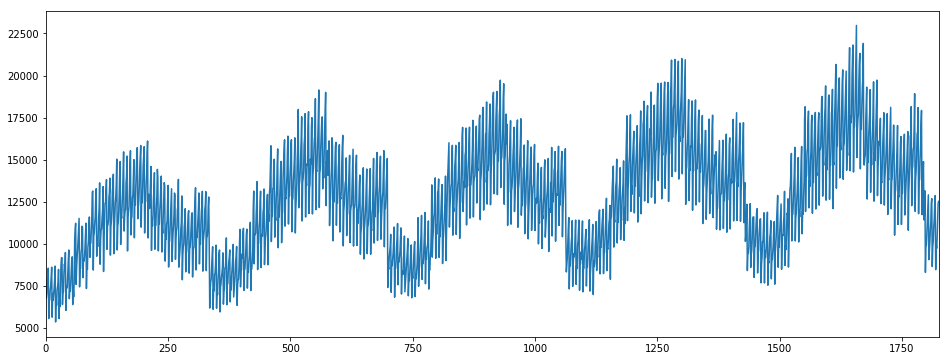

In [10]:
plt.figure(figsize=(16,6))
sns.tsplot(d_df.y)

In [11]:
d_df.index

RangeIndex(start=0, stop=1826, step=1)